## Joint Transit and Rositter-Mclaughlin Effect Fitting using updated GaiaRV

* This notebook is inspired by one of the tutorials of **`rmfit`**.
* The data for this notebook was also taken from **`rmfit`** data examples.
* **`rmfit`: https://github.com/gummiks/rmfit/**
* **Data origins: https://ui.adsabs.harvard.edu/abs/2022ApJ...931L..15S/abstract**

In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

In [7]:
#We first get the light curve data of GJ 3460.
datalc = pd.read_csv('../../data/lcdata/GJ3470b_transit.mrt', skiprows=22,
                   header=None, delim_whitespace=True, names=['bjd','f','e','model','gp','ntransit'])
datalc = datalc[datalc.ntransit==1]
datalc

bjd         f         e     model        gp  ntransit
0    2.458820e+06  0.999634  0.001009  0.999914  0.999941         1
1    2.458820e+06  0.999745  0.001008  0.999916  0.999943         1
2    2.458820e+06  0.999077  0.001007  0.999918  0.999944         1
3    2.458820e+06  0.999615  0.001005  0.999923  0.999947         1
4    2.458820e+06  0.998409  0.001004  0.999928  0.999953         1
..            ...       ...       ...       ...       ...       ...
558  2.458820e+06  1.003328  0.000787  1.002304  1.002290         1
559  2.458820e+06  1.001992  0.000787  1.002307  1.002292         1
560  2.458820e+06  1.002344  0.000787  1.002312  1.002296         1
561  2.458820e+06  1.002270  0.000787  1.002316  1.002298         1
562  2.458820e+06  1.002864  0.000787  1.002320  1.002301         1

[563 rows x 6 columns]

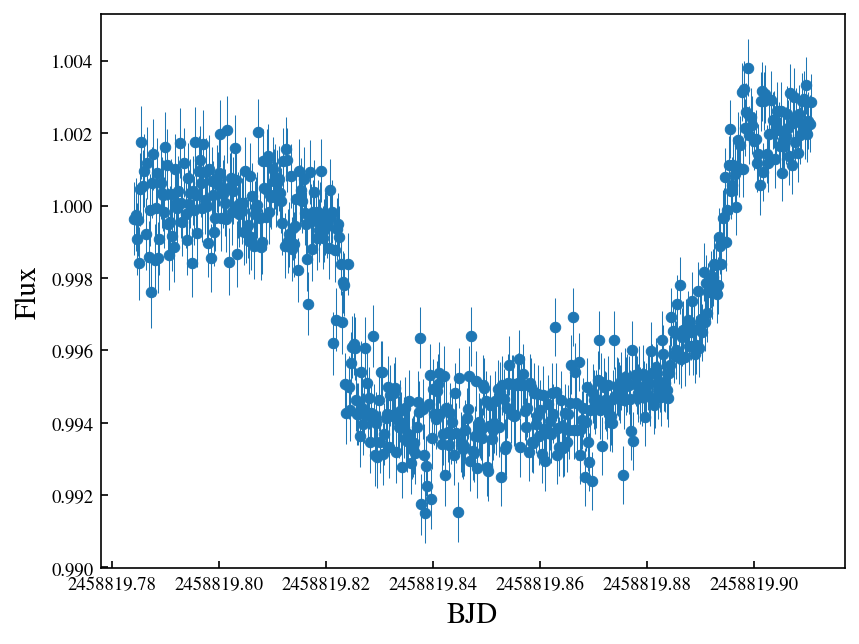

In [8]:
#We plot the Light Curve Data we have.
fig, ax = plt.subplots(dpi=150)
ax.errorbar(datalc.bjd.values, datalc.f.values, datalc.e.values, marker='o', 
            lw=0, mew=0.5, capsize=0, elinewidth=0.5,)
ax.set_xlabel('BJD', fontsize=14)
ax.set_ylabel('Flux', fontsize=14)

plt.show();

In [9]:
#We then get the (In Transit) Radial Velocity data of GJ3470.
datarv = pd.read_csv('../../data/rvdata/GJ3470b_intransitrv.mrt',
                     skiprows=19,header=None,delim_whitespace=True,names=['bjd','rv','e','ntransit'])
datarv = datarv[datarv.ntransit==0]
datarv

bjd    rv     e  ntransit
0   2.459217e+06  0.50  1.90         0
1   2.459217e+06  0.84  1.84         0
2   2.459217e+06  0.72  1.81         0
3   2.459217e+06 -1.00  1.94         0
4   2.459217e+06  2.32  1.76         0
5   2.459217e+06  0.64  1.67         0
6   2.459217e+06  4.67  1.69         0
7   2.459217e+06 -0.56  1.77         0
8   2.459217e+06 -3.01  1.62         0
9   2.459217e+06 -0.34  1.57         0
10  2.459217e+06  0.70  1.59         0
11  2.459217e+06 -1.08  1.51         0
12  2.459217e+06 -0.69  1.46         0
13  2.459217e+06 -1.44  1.44         0
14  2.459217e+06 -0.53  1.44         0
15  2.459217e+06 -1.68  1.54         0
16  2.459217e+06  0.63  1.58         0
17  2.459217e+06 -0.95  1.59         0
18  2.459217e+06 -0.34  1.55         0
19  2.459217e+06  1.46  1.67         0
20  2.459217e+06  2.14  1.77         0
21  2.459217e+06 -1.69  1.78         0
22  2.459217e+06 -1.47  1.88         0
23  2.459217e+06 -0.20  1.90         0
24  2.459217e+06  0.37  2.00         0

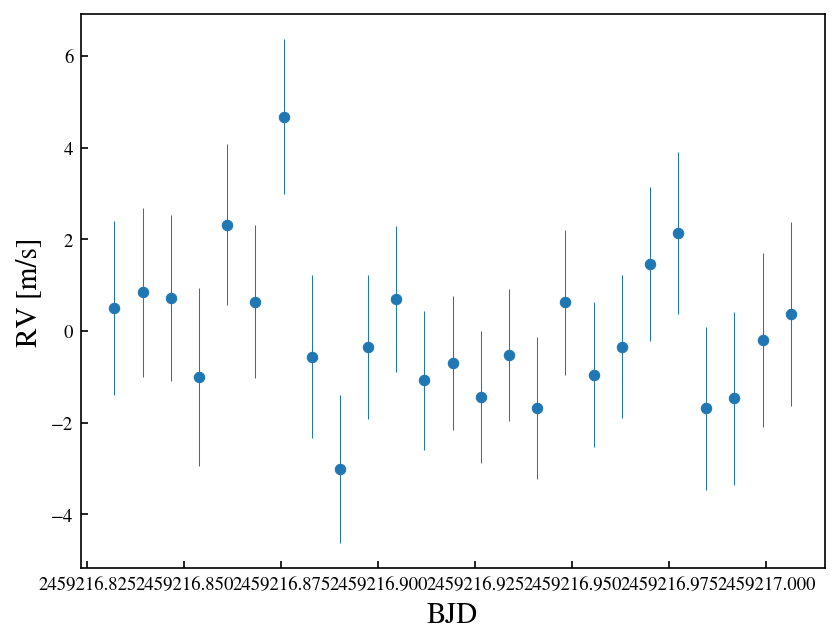

In [10]:
#We plot the Radial Velocity data we have.
fig, ax = plt.subplots(dpi=150)
ax.errorbar(datarv.bjd.values, datarv.rv.values, datarv.e.values, marker='o',
            lw=0, mew=0.5, capsize=0, elinewidth=0.5,)
ax.set_xlabel('BJD', fontsize=14)
ax.set_ylabel('RV [m/s]', fontsize=14)

plt.show();

In [25]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/utils.py'>)

In [26]:
#We get the Prior File for the target we are analyzing as follows.
#Please open one of the .txt files to see how to setup the Prior Files.
f = '../../data/priors/GJ3470b_Priors.txt'
reload(gaiafitwithtransit)

<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>

In [13]:
#We will be using LPFunction1RM1Phot from the gaiarv code.
#For this to work, we need to define a dictionary that will store both LC and RV data.
inputdata = {}

#We add the RV times, velocities and velocity errors.
inputdata["time_rv1"] = datarv.bjd.values
inputdata["rv_rv1"] = datarv.rv.values
inputdata["e_rv1"] = datarv.e.values

#We add the Transit times, fluxes and the flux errors.
inputdata["time_tr1"] = datalc.bjd.values
inputdata["f_tr1"] = datalc.f.values
inputdata["e_tr1"] = datalc.e.values

inputdata

{'time_rv1': array([2459216.831977, 2459216.839241, 2459216.846506, 2459216.853771,
        2459216.861036, 2459216.868301, 2459216.875566, 2459216.882831,
        2459216.890096, 2459216.897361, 2459216.904626, 2459216.911891,
        2459216.919156, 2459216.926421, 2459216.933687, 2459216.940952,
        2459216.948217, 2459216.955482, 2459216.962747, 2459216.970012,
        2459216.977277, 2459216.984542, 2459216.991807, 2459216.999072,
        2459217.006337]),
 'rv_rv1': array([ 0.5 ,  0.84,  0.72, -1.  ,  2.32,  0.64,  4.67, -0.56, -3.01,
        -0.34,  0.7 , -1.08, -0.69, -1.44, -0.53, -1.68,  0.63, -0.95,
        -0.34,  1.46,  2.14, -1.69, -1.47, -0.2 ,  0.37]),
 'e_rv1': array([1.9 , 1.84, 1.81, 1.94, 1.76, 1.67, 1.69, 1.77, 1.62, 1.57, 1.59,
        1.51, 1.46, 1.44, 1.44, 1.54, 1.58, 1.59, 1.55, 1.67, 1.77, 1.78,
        1.88, 1.9 , 2.  ]),
 'time_tr1': array([2458819.784088, 2458819.78431 , 2458819.784532, 2458819.784754,
        2458819.784976, 2458819.785198, 2458819.78

In [14]:
#We then use "LPFunction1RM1Phot" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #1RM => Tells you that it is doing an RM fit.
    #1Phot => Tells you that it is doing a transit fit. (Photometric)

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunction1RM1Phot(inputdata,file_priors=f)

#We do a Gaia Fit as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.RMFit(L)

Reading in priorfile from ../../data/priors/GJ3470b_Priors.txt
   prior          arg1        arg2            label      description  \
0     NP  2.456341e+06    0.000100            t0_p1            t0_p1   
1     NP  3.336653e+00    0.000003             P_p1             P_p1   
2     UP -1.800000e+02  180.000000           lam_p1           lam_p1   
3     UP  0.000000e+00   10.000000            vsini            vsini   
4     UP  8.000000e+01   90.000000           inc_p1           inc_p1   
5     UP  0.000000e+00    0.200000             p_p1             p_p1   
6     UP  5.000000e+00   30.000000             a_p1             a_p1   
7     NP  3.500000e-01    0.100000           u1_rv1           u1_rv1   
8     NP  3.200000e-01    0.050000           u2_rv1           u2_rv1   
9     NP  3.500000e-01    0.100000           u1_tr1           u1_tr1   
10    NP  3.200000e-01    0.050000           u2_tr1           u2_tr1   
11    NP  1.250000e-01    0.042000           ecc_p1           ecc_p1   
1

In [15]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=2000,npop=60)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
          labels       centers         lower         upper            pv  center_dist
0          t0_p1  2.456341e+06  2.456341e+06  2.456341e+06  2.456341e+06    -0.000212
1           P_p1  3.336653e+00  3.336637e+00  3.336669e+00  3.336651e+00     0.000001
2         lam_p1  0.000000e+00 -1.800000e+02  1.800000e+02  1.201356e+02  -120.135577
3          vsini  5.000000e+00  0.000000e+00  1.000000e+01  5.304135e-01     4.469586
4         inc_p1  8.500000e+01  8.000000e+01  9.000000e+01  8.868026e+01    -3.680256
5           p_p1  1.000000e-01  0.000000e+00  2.000000e-01  7.825697e-02     0.021743
6           a_p1  1.750000e+01  5.000000e+00  3.000000e+01  1.554077e+01     1.959226
7         u1_rv1  3.500000e-01 -1.500000e-01  8.500000e-01  5.118432e-01    -0.161843
8         u2_rv1  3.200000e-01  7.000000e-02  5.700000e-01  1.429834e-01     0.177017
9         u1_tr1  3.500000e-01 -1.500000e-01  8.500000e-01  2.641097e-01     0

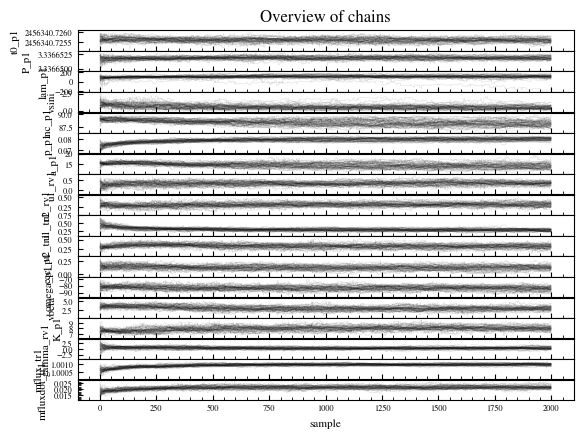

In [16]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [19]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase.
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

t0_p1      P_p1      lam_p1     vsini     inc_p1      p_p1  \
0      2.456341e+06  3.336652  111.374639  0.307986  88.659127  0.078254   
1      2.456341e+06  3.336652  111.374639  0.307986  88.659127  0.078254   
2      2.456341e+06  3.336652  111.374639  0.307986  88.659127  0.078254   
3      2.456341e+06  3.336652  111.374639  0.307986  88.659127  0.078254   
4      2.456341e+06  3.336652  111.374639  0.307986  88.659127  0.078254   
...             ...       ...         ...       ...        ...       ...   
59995  2.456341e+06  3.336652   95.145828  0.915727  88.770922  0.078804   
59996  2.456341e+06  3.336652   95.145828  0.915727  88.770922  0.078804   
59997  2.456341e+06  3.336652   95.145828  0.915727  88.770922  0.078804   
59998  2.456341e+06  3.336652   95.145828  0.915727  88.770922  0.078804   
59999  2.456341e+06  3.336652   95.145828  0.915727  88.770922  0.078804   

            a_p1    u1_rv1    u2_rv1    u1_tr1    u2_tr1    ecc_p1   omega_p1  \
0      15.180145  0.318308  0.332627  0.337152  0.404986  0.132116 -82.843399   
1      15.180145  0.318308  0.332627  0.337152  0.404986  0.132116 -82.843399   
2      15.180145  0.318308  0.332627  0.337152  0.404986  0.132116 -82.843399   
3      15.180145  0.318308  0.332627  0.337152  0.404986  0.132116 -82.843399   
4      15.180145  0.318308  0.332627  0.337152  0.404986  0.132116 -82.843399   
...          ...       ...       ...       ...       ...       ...        ...   
59995  15.640783  0.395284  0.377733  0.269234  0.301160  0.140998 -82.660660   
59996  15.640783  0.395284  0.377733  0.269234  0.301160  0.140998 -82.660660   
59997  15.640783  0.395284  0.377733  0.269234  0.301160  0.140998 -82.660660   
59998  15.640783  0.395284  0.377733  0.269234  0.301160  0.140998 -82.660660   
59999  15.640783  0.395284  0.377733  0.269234  0.301160  0.140998 -82.660660   

          vbeta      K_p1  gamma_rv1  mflux_tr1  mfluxdot_tr1  
0      2.147851  7.969525   0.314723   1.000963      0.022057  
1      2.147851  7.969525   0.314723   1.000963      0.022057  
2      2.147851  7.969525   0.314723   1.000963      0.022057  
3      2.147851  7.969525   0.314723   1.000963      0.022057  
4      2.147851  7.969525   0.314723   1.000963      0.022057  
...         ...       ...        ...        ...           ...  
59995  3.321984  8.031259   1.378177   1.000980      0.021934  
59996  3.321984  8.031259   1.378177   1.000980      0.021934  
59997  3.321984  8.031259   1.378177   1.000980      0.021934  
59998  3.321984  8.031259   1.378177   1.000980      0.021934  
59999  3.321984  8.031259   1.378177   1.000980      0.021934  

[60000 rows x 18 columns]

In [20]:
#To assess the convergence, we check the following percents.
#If good, the percent should be close to 1.
#If not good, then we need to run MCMC for more steps.
    #For this target note that we would need a lot more steps.
mcmc_help.gelman_rubin(chains_after_burnin)

array([1.20502822, 1.26272706, 1.54065521, 1.3013833 , 1.44626712,
       1.38193184, 1.38123575, 1.22985095, 1.2203648 , 1.34321574,
       1.16954073, 1.27797097, 1.22081336, 1.24234849, 1.24755063,
       1.17723843, 1.21110342, 1.25422793])

In [21]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                  values
0         t0_p1     $2456340.72559_{-0.0001}^{+0.0001}$
0          P_p1  $3.33665191_{-0.0000003}^{+0.0000003}$
0        lam_p1                 $107.0_{-22.0}^{+26.0}$
0         vsini                  $0.47_{-0.26}^{+0.29}$
0        inc_p1                  $88.2_{-0.50}^{+0.64}$
0          p_p1            $0.0801_{-0.0016}^{+0.0013}$
0          a_p1                    $14.3_{-1.1}^{+1.3}$
0        u1_rv1                $0.346_{-0.099}^{+0.10}$
0        u2_rv1               $0.313_{-0.048}^{+0.052}$
0        u1_tr1               $0.284_{-0.036}^{+0.040}$
0        u2_tr1               $0.321_{-0.053}^{+0.050}$
0        ecc_p1               $0.126_{-0.042}^{+0.040}$
0      omega_p1                   $-83.1_{-3.1}^{+2.9}$
0         vbeta                  $2.98_{-0.49}^{+0.47}$
0          K_p1                  $8.05_{-0.34}^{+0.36}$
0     gamma_rv1                  $0.36_{-0.41}^{+0.42}$
0     mflux_tr1         $1.00099_{-0.00006}^{+0.00006}$
0  mfluxdot_tr1            $0.0214_{-0.0011}^{+0.0012}$

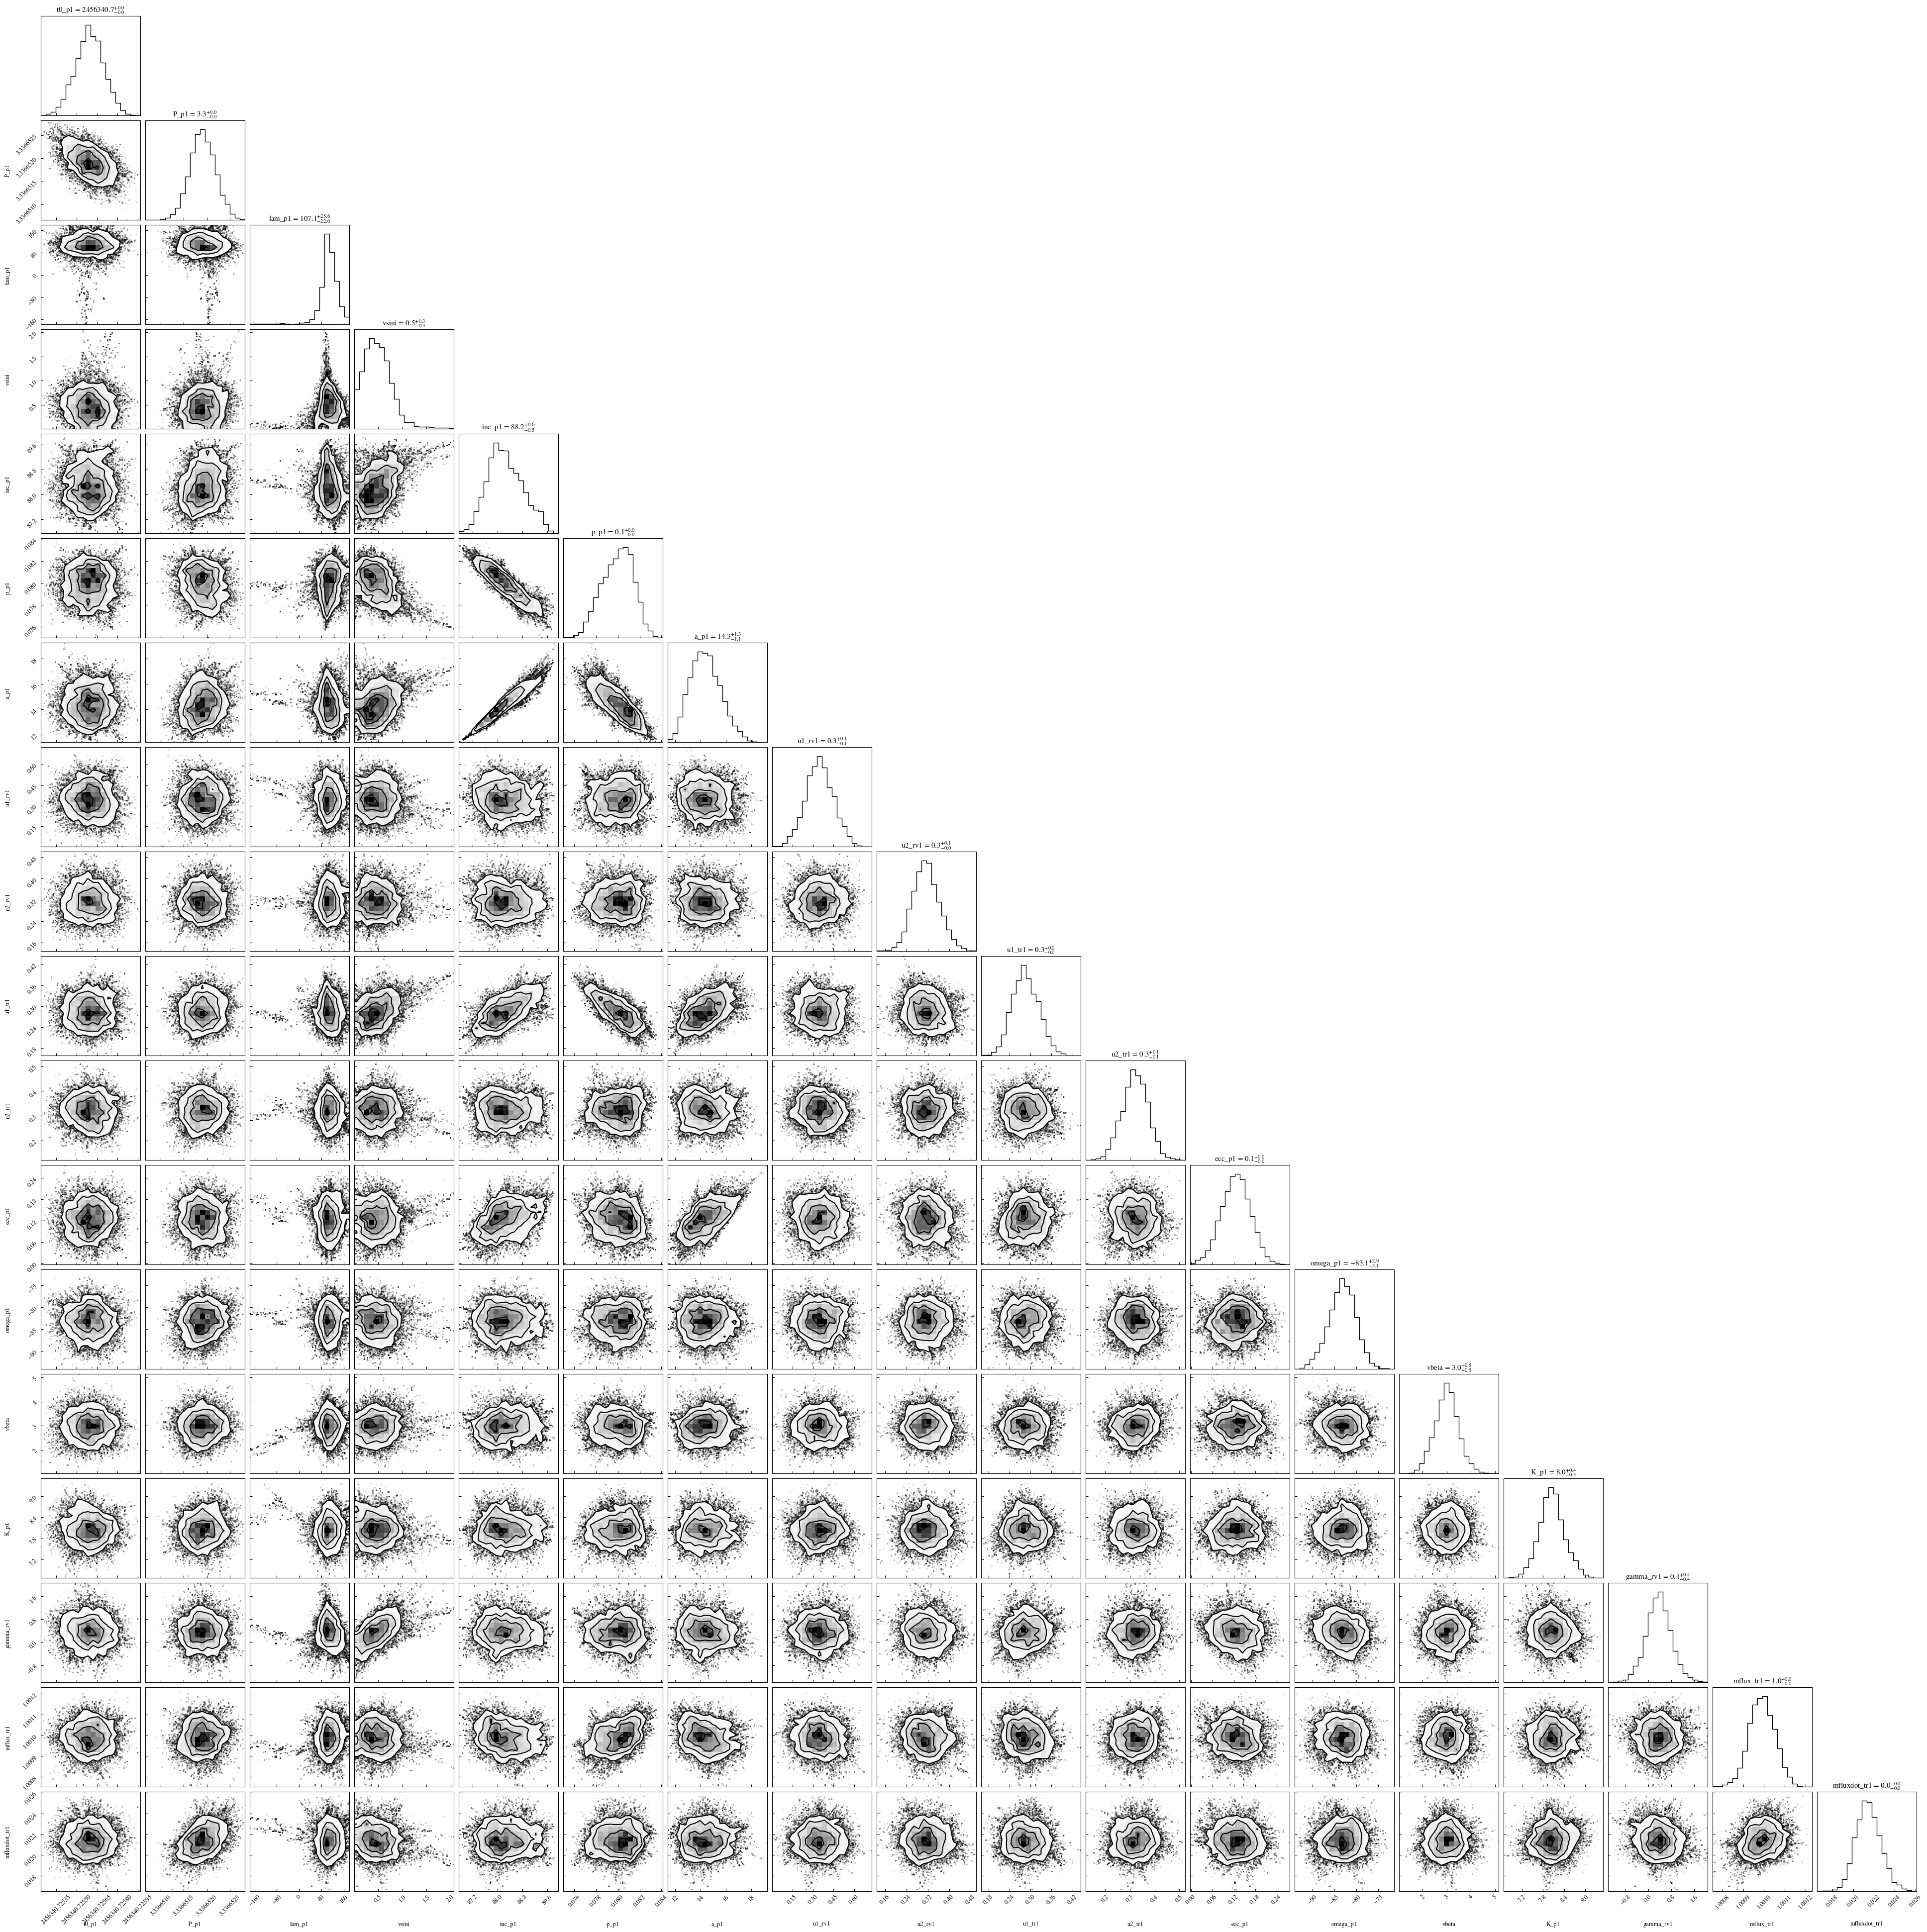

In [22]:
#We then plot the Corner Plot.
import corner
corner.corner(df_post.values,
       show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

plt.show();

Sampling, i= 0
Sampling, i= 100
Sampling, i= 200
Sampling, i= 300
Sampling, i= 400
Sampling, i= 500
Sampling, i= 600
Sampling, i= 700
Sampling, i= 800
Sampling, i= 900


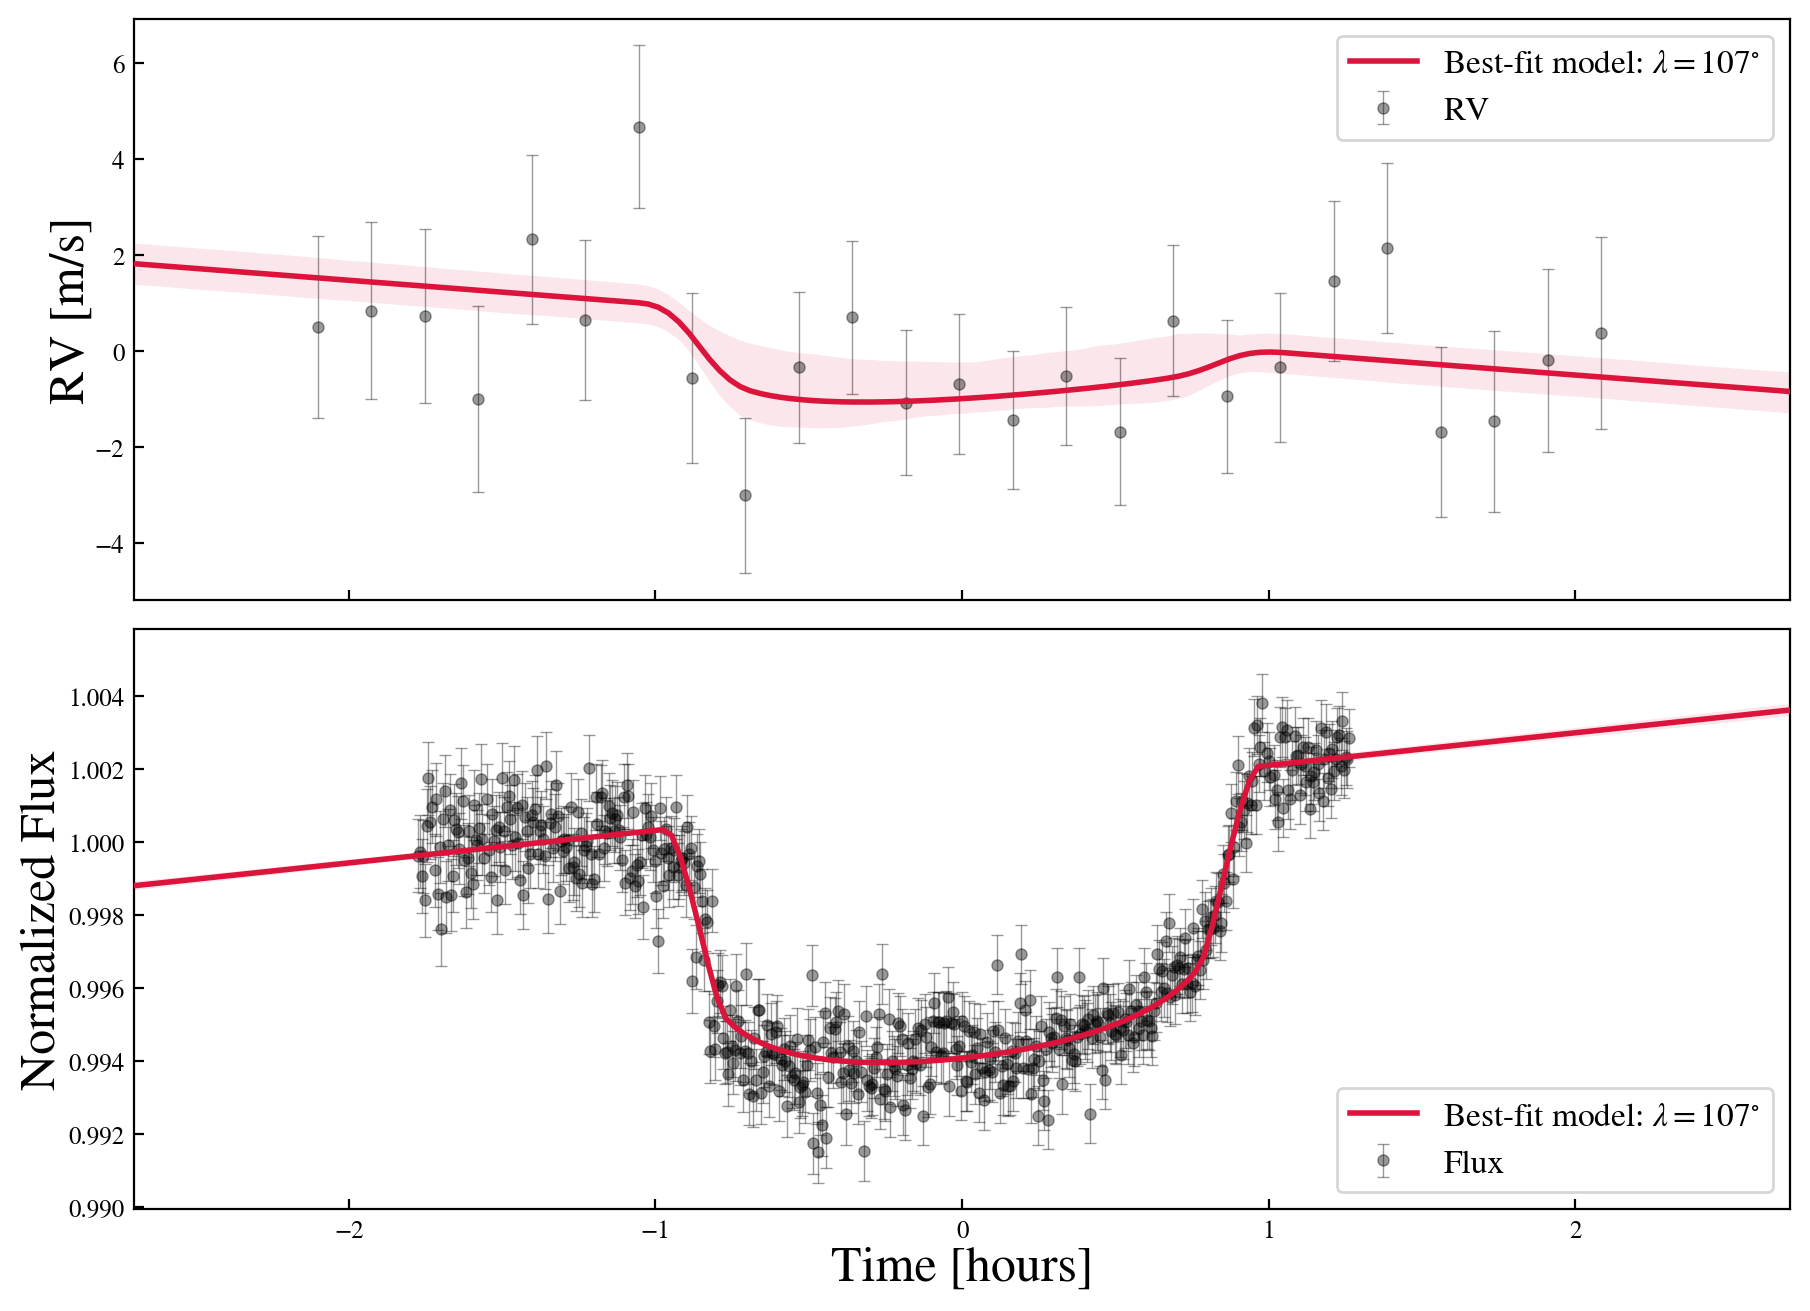

In [30]:
NBIN = 2

P = df_medvals.medvals.values[df_medvals.Labels=='P_p1'][0]
T0 = df_medvals.medvals.values[df_medvals.Labels=='t0_p1'][0]

t01 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_rv1'][0],P,T0)
t02 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_tr1'][0],P,T0)

markercolor="black"
shadecolor="crimson"
ALPHA=0.4

flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

times1 = np.linspace(TF.lpf.data_rv1['time'][0]-0.02,TF.lpf.data_rv1['time'][-1]+0.02,500)
times2 = np.linspace(TF.lpf.data_tr1['time'][0]-0.02,TF.lpf.data_tr1['time'][-1]+0.02,500)

pv_50 = np.percentile(flatchain,[50],axis=0)[0]
s1 = 0.
s2 = 0.
t1_mod = np.linspace(times1.min()-0.1,times1.max()+0.1,300)
t2_mod = np.linspace(times2.min()-0.1,times2.max()+0.1,300)
rv_50_1, ff_50_1 = TF.lpf.compute_total_model(pv_50,times_rv1=t1_mod,times_tr1=t2_mod)

gamma1 = TF.lpf.get_jump_parameter_value(pv_50,'gamma_rv1')
mflux = TF.lpf.get_jump_parameter_value(pv_50,'mflux_tr1')

# Plot random samples
fig, (ax,bx) = plt.subplots(nrows=2,ncols=1,dpi=200,figsize=(9,7),sharex=True)
#################
# Transit 1
#################

ax.errorbar((TF.lpf.data_rv1['time']-t01)*24,TF.lpf.data_rv1['y'],np.sqrt(TF.lpf.data_rv1['error']**2.+s1**2.),
            marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='RV')
ax.plot((t1_mod-t01)*24.,rv_50_1,color="crimson",
        label=r'Best-fit model: $\lambda=${:0.0f}'.format(pv_50[2])+'$^{\circ}$',lw=2.,zorder=10)


#################
# Transit 2
#################
bx.errorbar((TF.lpf.data_tr1['time']-t02)*24,TF.lpf.data_tr1['y'],np.sqrt(TF.lpf.data_tr1['error']**2.+s2**2.),
            marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='Flux')
bx.plot((t2_mod-t02)*24.,ff_50_1,color="crimson",
        label=r'Best-fit model: $\lambda=${:0.0f}'.format(pv_50[2])+'$^{\circ}$',lw=2.,zorder=10)


#################
# Sample models
#################
mmodel1 = []
mmodel2 = []
idx = np.random.choice(range(len(flatchain)),1000)
for i in range(1000):
    if i%100 == 0: print("Sampling, i=",i)
    #idx = #np.random.randint(0, flatchain.shape[0])
    m1,m2 = TF.lpf.compute_total_model(flatchain[idx[i]],times_rv1=t1_mod,times_tr1=t2_mod)
    mmodel1.append(m1)
    mmodel2.append(m2)
mmodel1 = np.array(mmodel1)
mmodel2 = np.array(mmodel2)


ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)

bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.16,axis=0),np.quantile(mmodel2,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.02,axis=0),np.quantile(mmodel2,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.0015,axis=0),np.quantile(mmodel2,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)

for xx in (ax,bx):
    xx.set_xlim(-2.7,2.7)
    xx.grid(lw=0)
    #xx.set_ylim(-14,14)
    
ax.set_ylabel("RV [m/s]",fontsize=18,labelpad=0)   
bx.set_ylabel('Normalized Flux',fontsize=18,labelpad=1)
bx.set_xlabel('Time [hours]',fontsize=18,labelpad=1)

ax.legend(loc='upper right',fontsize=12)

bx.legend(loc='lower right',fontsize=12)

fig.subplots_adjust(wspace=0.02,hspace=0.05,right=0.98,left=0.06,top=0.95,bottom=0.1)

plt.show();